<a href="https://colab.research.google.com/github/gushenri/LesoesBasquete/blob/main/LesoesBasquete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Manipulação de dados

import numpy as np   # Biblioteca para cálculo numérico, vetores, matrizes, álgebra linear e estatística
import pandas as pd  # Biblioteca para manipulação de dados em tabelas (DataFrames), leitura e escrita de CSV/Excel
from IPython.display import display  # Usado em notebooks (como Kaggle e Jupyter) para exibir DataFrames e objetos de forma mais bonita
import kagglehub

#Pré-processamento de Dados

from sklearn.preprocessing import StandardScaler  # Normaliza/Padroniza dados numéricos (média 0, desvio padrão 1)
from sklearn.preprocessing import LabelEncoder    # Converte variáveis categóricas em números (ex.: 'Masculino' -> 0, 'Feminino' -> 1)

#Modelos de Machine Learning

from sklearn.linear_model import LogisticRegression   # Modelo de classificação (regressão logística)
from sklearn.model_selection import train_test_split  # Divide o dataset em treino e teste
from sklearn.ensemble import RandomForestClassifier   # Modelo de classificação baseado em várias árvores de decisão


#Avaliação de Modelos
from sklearn.metrics import classification_report  # Gera métricas como precisão, recall e f1-score

#Geração de dados
!pip install ctgan   # Instala o CTGAN (modelos generativos para criar dados tabulares sintéticos)
!pip install sdv     # Instala o Synthetic Data Vault (framework para gerar dados sintéticos)

import os  # Biblioteca padrão para navegar em pastas e manipular caminhos de arquivos

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/basketball-player-injury-in-sports-rehabilitation/basketball_injury_biomechanical_dataset.csv


In [ ]:
path = kagglehub.dataset_download("ziya07/basketball-player-injury-in-sports-rehabilitation")



Analisando os dados

In [ ]:
print(" Dataset baixado em:", path)

#Listar os arquivos disponíveis dentro da pasta baixada
print("\nArquivos disponíveis no dataset:")
print(os.listdir(path))

# Definindo o arquivo CSV
csv_path = os.path.join(path, "basketball_injury_biomechanical_dataset.csv")



 Dataset baixado em: /kaggle/input/basketball-player-injury-in-sports-rehabilitation

Arquivos disponíveis no dataset:
['basketball_injury_biomechanical_dataset.csv']


In [ ]:
# Carregar no Pandas
df = pd.read_csv(csv_path)

# 5. Mostrar primeiras linhas
print("\nVisualizando as primeiras linhas do dataset:")
print(df.head())


Visualizando as primeiras linhas do dataset:
   Player_ID  Age  Height_cm  Weight_kg Position           Injury_Type  \
0          1   24        195        108   Center              ACL Tear   
1          2   32        183         87  Forward          Ankle Sprain   
2          3   28        208        109   Center           Knee Injury   
3          4   25        196         70  Forward  Shoulder Dislocation   
4          5   24        178         80    Guard  Shoulder Dislocation   

  Injury_Severity Rehabilitation_Program  Rehabilitation_Time_weeks  \
0          Severe          Physiotherapy                          7   
1            Mild          Physiotherapy                          8   
2        Moderate  Flexibility Exercises                          3   
3        Moderate      Strength Training                         11   
4        Moderate       Balance Training                          3   

   Injury_Recurrence Date_of_Injury  Rehabilitation_Efficiency_Score  \
0         

In [ ]:


def get_real_valued_columns(df, min_unique=3):
    # Seleciona os nomes das colunas cujo tipo é numérico (int, float, etc.).
    # Usar include='number' garante que qualquer subtipo numérico será considerado
    # (ex.: int32, float64, Int64 "nullable" do pandas).
    num_cols = df.select_dtypes(include='number').columns

    # Para cada coluna numérica, conta quantos valores distintos existem com nunique().
    # dropna=True faz com que NaN não seja contabilizado como valor distinto.
    # Mantém apenas as colunas em que a quantidade de valores únicos é >= min_unique.
    # Por padrão min_unique=3, o que tende a excluir variáveis binárias (0/1) e manter
    # variáveis contínuas ou discretas com mais níveis.
    return [c for c in num_cols if df[c].nunique(dropna=True) >= min_unique]


In [ ]:
# 1. Remove the useless columns. Replace Injury_Severety with just a binary value
df = df.drop(columns=['Date_of_Injury', 'Player_ID'])

# Create binary target column from the Injury_Severity feature
df['Is_injury_severe'] = df['Injury_Severity'].replace({'Mild': 0, 'Moderate': 0, 'Severe': 1})
df = df.drop(columns=['Injury_Severity'])

# 2. Scale the numerical features
numeric_cols = get_real_valued_columns(df)
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 3. One-hot encode the position feature
df = pd.get_dummies(df, columns=['Position'])
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# 4. Label Encode the categorical features
#categorical_cols = df.select_dtypes(include=['object', 'category']).columns
#label_encoders = {}
#for col in categorical_cols:
#    le = LabelEncoder()
#    df[col] = le.fit_transform(df[col])
#    label_encoders[col] = le


df.head()

/tmp/ipython-input-3529314446.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Is_injury_severe'] = df['Injury_Severity'].replace({'Mild': 0, 'Moderate': 0, 'Severe': 1})


,Age,Height_cm,Weight_kg,Injury_Type,Rehabilitation_Program,Rehabilitation_Time_weeks,Injury_Recurrence,Rehabilitation_Efficiency_Score,knee_angle_deg,jump_height_cm,ankle_flexion_deg,speed_m_s,reaction_time_ms,Is_injury_severe,Position_Center,Position_Forward,Position_Guard
0,-0.307603,0.409432,1.398741,ACL Tear,Physiotherapy,0.027195,0,0.799828,0.902931,0.496283,-1.115607,-0.398649,-0.147673,1,1,0,0
1,1.355114,-0.585139,-0.445174,Ankle Sprain,Physiotherapy,0.367135,0,0.418595,-1.471980,0.784916,1.879405,0.364120,-0.997717,0,0,1,0
2,0.523756,1.486884,1.486546,Knee Injury,Flexibility Exercises,-1.332563,0,-0.243944,1.300579,0.181476,1.377914,-0.802951,1.431387,0,1,0,0
3,-0.099763,0.492313,-1.937866,Shoulder Dislocation,Strength Training,1.386953,0,1.502550,0.674974,-0.273379,-1.076349,0.486734,1.293180,0,0,1,0
4,-0.307603,-0.999544,-1.059812,Shoulder Dislocation,Balance Training,-1.332563,1,1.276247,-1.317149,-0.492389,1.659490,-0.291011,-1.573832,0,0,0,1


In [ ]:

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import matplotlib.pyplot as plt

# 1. Preparar o conjunto de dados
# Converter colunas booleanas para inteiros
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Garantir que não existam valores ausentes (NaN)
assert not df.isnull().any().any(), "Data contains missing values."

# 2. Definir metadados (inferidos automaticamente)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

# 3. Inicializar e treinar o sintetizador CTGAN
synthesizer = CTGANSynthesizer(metadata=metadata)
synthesizer.fit(df)

# 4. Gerar dados sintéticos
synthetic_df = synthesizer.sample(num_rows=900)

# 5. Combinar dados originais e sintéticos
df = pd.concat([df, synthetic_df], ignore_index=True)

print(f"Augmented dataset shape: {df.shape}")


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:167: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:133: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Augmented dataset shape: (1000, 17)


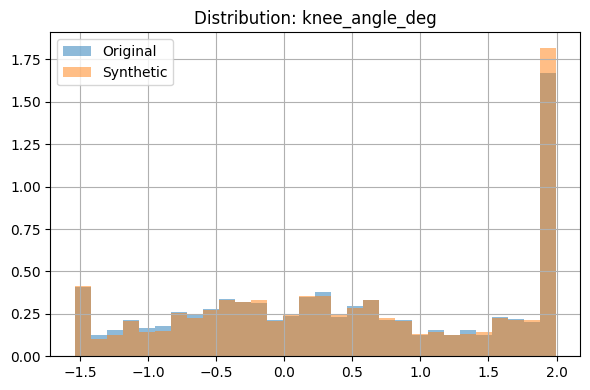

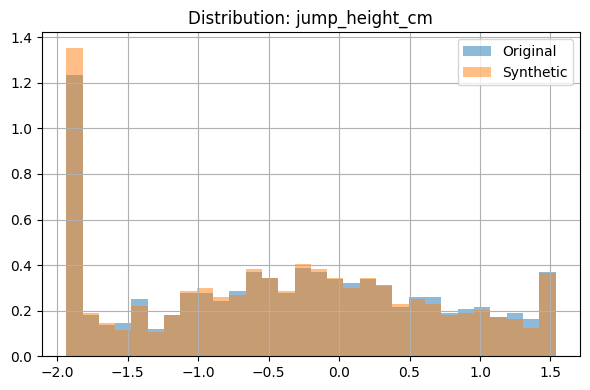

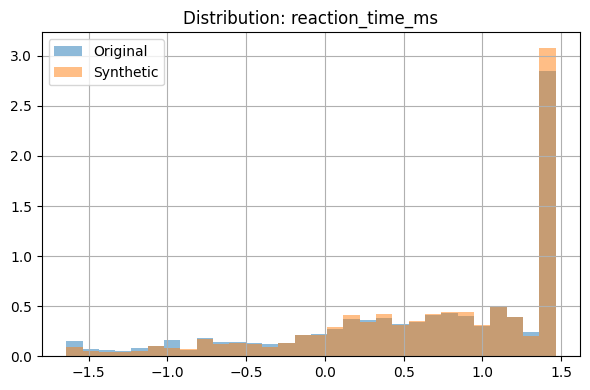

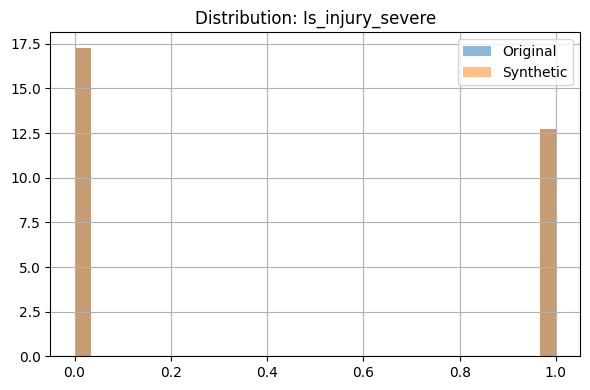

In [ ]:
# 6. Compare distributions for selected features
features_to_plot = ['knee_angle_deg', 'jump_height_cm', 'reaction_time_ms', 'Is_injury_severe']

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    plt.hist(df[feature], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(synthetic_df[feature], bins=30, alpha=0.5, label='Synthetic', density=True)
    plt.title(f'Distribution: {feature}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#Dividindo em 3 grupos:
# 1. Informações Pessoais & Demográficas
# Seleciona colunas relacionadas ao perfil do jogador (idade, altura, peso e posição em quadra)
player_info_cols = [
    'Age', 'Height_cm', 'Weight_kg', 'Position_Center', 'Position_Forward', 'Position_Guard'
]
player_info_df = df[player_info_cols]  # cria um DataFrame só com essas informações

# 2. Dados biomecânicos de movimento
# Seleciona colunas que medem aspectos físicos e de desempenho
biomechanical_cols = [
    'knee_angle_deg',      # ângulo do joelho em graus
    'jump_height_cm',      # altura do salto em centímetros
    'ankle_flexion_deg',   # flexão do tornozelo em graus
    'speed_m_s',           # velocidade em metros por segundo
    'reaction_time_ms',    # tempo de reação em milissegundos
]
biomechanical_df = df[biomechanical_cols]

# Combina as duas tabelas acima (informações pessoais + biomecânicas) em uma tabela de características do jogador
player_features_df = pd.concat([player_info_df, biomechanical_df], axis=1)

# 3. Informações sobre lesões
# Seleciona colunas relacionadas a tipo e gravidade da lesão
injury_cols = ['Injury_Type', 'Is_injury_severe', 'Injury_Recurrence']
injury_df = df[injury_cols]

# 4. Informações sobre reabilitação
# Seleciona colunas que descrevem o processo e a eficiência da reabilitação
rehab_cols = [
    'Rehabilitation_Program',             # tipo de programa de reabilitação
    'Rehabilitation_Time_weeks',          # tempo de reabilitação em semanas
    'Rehabilitation_Efficiency_Score'     # pontuação de eficiência da reabilitação
]
rehab_df = df[rehab_cols]

# Exibe os dados divididos em diferentes categorias
print("🔹 Características do Jogador")
display(player_features_df.head())  # primeiras linhas das características do jogador

print("🔹 Informações de Lesões")
display(injury_df.head())           # primeiras linhas de informações sobre lesões

print("🔹 Informações de Reabilitação")
display(rehab_df.head())            # primeiras linhas de informações sobre reabilitação




🔹 Características do Jogador


,Age,Height_cm,Weight_kg,Position_Center,Position_Forward,Position_Guard,knee_angle_deg,jump_height_cm,ankle_flexion_deg,speed_m_s,reaction_time_ms
0,-0.307603,0.409432,1.398741,1,0,0,0.902931,0.496283,-1.115607,-0.398649,-0.147673
1,1.355114,-0.585139,-0.445174,0,1,0,-1.471980,0.784916,1.879405,0.364120,-0.997717
2,0.523756,1.486884,1.486546,1,0,0,1.300579,0.181476,1.377914,-0.802951,1.431387
3,-0.099763,0.492313,-1.937866,0,1,0,0.674974,-0.273379,-1.076349,0.486734,1.293180
4,-0.307603,-0.999544,-1.059812,0,0,1,-1.317149,-0.492389,1.659490,-0.291011,-1.573832


🔹 Informações de Lesões


,Injury_Type,Is_injury_severe,Injury_Recurrence
0,ACL Tear,1,0
1,Ankle Sprain,0,0
2,Knee Injury,0,0
3,Shoulder Dislocation,0,0
4,Shoulder Dislocation,0,1


🔹 Informações de Reabilitação


,Rehabilitation_Program,Rehabilitation_Time_weeks,Rehabilitation_Efficiency_Score
0,Physiotherapy,0.027195,0.799828
1,Physiotherapy,0.367135,0.418595
2,Flexibility Exercises,-1.332563,-0.243944
3,Strength Training,1.386953,1.502550
4,Balance Training,-1.332563,1.276247


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# ===== Hiperparâmetros solicitados =====
n_camadas_ocultas = 2        # número de camadas ocultas
n_neuronios = 64             # número de neurônios por camada
taxa_aprendizado = 1e-3      # learning_rate_init (taxa de aprendizagem)

# Monta a tupla do tamanho das camadas ocultas (repete 'n_neuronios' 'n_camadas_ocultas' vezes)
hidden_sizes = (n_neuronios,) * n_camadas_ocultas
# Se quiser tamanhos diferentes por camada, defina manualmente, ex.: hidden_sizes = (128, 64, 32)

injury_reports = {}
injury_perm_importances = {}

for injury_code in injury_df['Injury_Type'].unique():
    # --- Subconjunto por tipo de lesão ---
    mask = injury_df['Injury_Type'] == injury_code
    X = player_features_df.loc[mask].copy()
    y = injury_df.loc[mask, 'Is_injury_severe'].copy()

    # Garantir apenas colunas numéricas para a MLP
    X = X.select_dtypes(include='number').copy()

    print(f"Injury: {injury_code} — Sample size: {len(y)}")

    # Pular se só existe uma classe
    if y.nunique() < 2:
        print("Skipping: only one class present.\n")
        continue

    # --- Split 70/30 (estratificado) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )

    # --- Pipeline: padronização + oversampling (apenas no fit) + MLP ---
    pipe = ImbPipeline(steps=[
        ('scaler', StandardScaler(with_mean=True, with_std=True)),   # padronização
        ('sampler', RandomOverSampler(random_state=42)),             # balanceamento só no treino
        ('clf', MLPClassifier(
            hidden_layer_sizes=hidden_sizes,         # usa os parâmetros definidos acima
            activation='relu',
            solver='adam',                           # backprop com Adam
            learning_rate_init=taxa_aprendizado,     # taxa de aprendizagem
            alpha=1e-4,                              # regularização L2
            max_iter=300,
            random_state=42,
            early_stopping=True,                     # evita overfitting
            n_iter_no_change=10,
            validation_fraction=0.1
        ))
    ])

    # --- Treino ---
    pipe.fit(X_train, y_train)

    # --- Avaliação ---
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    # Guardar relatório como dict
    injury_reports[injury_code] = classification_report(
        y_test, y_pred, output_dict=True
    )

    # --- Importância via Permutation Importance no conjunto de teste ---
    pi = permutation_importance(
        pipe, X_test, y_test,
        n_repeats=10, random_state=42, scoring='f1'
    )
    perm_series = pd.Series(pi.importances_mean, index=X_test.columns) \
                    .sort_values(ascending=False)

    injury_perm_importances[injury_code] = perm_series

    print("Top 3 features (Permutation Importance):")
    print(perm_series.head(3).round(3))
    print("-" * 50)


Injury: ACL Tear — Sample size: 205
              precision    recall  f1-score   support

           0      0.600     0.429     0.500        35
           1      0.459     0.630     0.531        27

    accuracy                          0.516        62
   macro avg      0.530     0.529     0.516        62
weighted avg      0.539     0.516     0.514        62

Top 3 features (Permutation Importance):
ankle_flexion_deg    0.085
Age                  0.042
reaction_time_ms     0.030
dtype: float64
--------------------------------------------------
Injury: Ankle Sprain — Sample size: 260
              precision    recall  f1-score   support

           0      0.512     0.512     0.512        43
           1      0.400     0.400     0.400        35

    accuracy                          0.462        78
   macro avg      0.456     0.456     0.456        78
weighted avg      0.462     0.462     0.462        78

Top 3 features (Permutation Importance):
Height_cm          0.021
Position_Center 